In [1]:
# ML_in_Finance_LSPI_Markowitz
# Author: Matthew Dixon
# Version: 1.0 (06.05.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6.9 and the following packages:
# matplotlib=3.1.3, pandas=1.0.3, numpy=1.18.1, scipy=1.4.1, bspline=0.1.1
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

## Mean-Variance Optimization with risky asset and cash

In [2]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import norm

from bspline import Bspline, splinelab

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters for MC simulation of stock prices

In [3]:
S0 = 100 # Initial stock price
mu = 0.03 # Drift
sigma = 0.20 # Volatility
r = 0.01 # Risk-free rate
M = 1 # Maturity

T = 30 # Number of time steps
delta_t = M / T # Time interval

N_MC = 2000 # Number of paths

gamma = np.exp(- r * delta_t) # Discount factor
lmbda = 10.0 # Risk aversion
alpha = 1.0 # Learning rate

## Create dataset

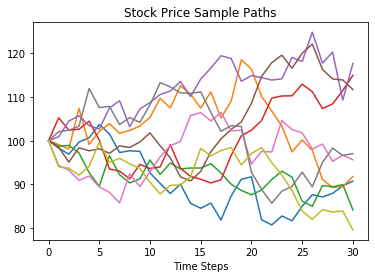

In [4]:
# Stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:, 0] = S0

# Standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC, T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:, t] = S.loc[:, t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:, t])
    
    # Or, using Euler for alpha-stable distributions:
    #S.loc[:, t] = S.loc[:, t-1]*(1 + mu*delta_t + sigma *S.loc[:,t-1]**(alpha-1)*np.sqrt(delta_t) * RN.loc[:,t])

# Plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()


$$C_t = -R_t= -r_t  + \lambda (r_t-\mu)^2  =  -(1-u_t)r_f - u_t  \phi_t  +  \lambda u_t^2 Var(\phi_t | S_t)$$ 

In [5]:
def negative_reward(mu, var, a, rf, lmbda):
    C = -(1-a)*rf - a*mu + lmbda*(a**2)*var
    return C

##  Define spline basis functions  

In [6]:
X = S # set the wealth (but not the total wealth) of the portfolio to be the stock price
p = 4 # order of spline (as-is; 3 = cubic, 4: B-spline)
ncolloc = 16
a_min = -1
a_max = 1

In [7]:
def get_basis_functions(X_min, X_max, a_min, a_max, ncolloc, p=3):
    tau_x = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we
    tau_a = np.linspace(a_min, a_max, ncolloc)  # would like to interpolate

    # k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
    # To get meaninful results, one should have ncolloc >= p+1
    k_x = splinelab.aptknt(tau_x, p)
    k_a = splinelab.aptknt(tau_a, p)
                             
    # Spline basis of order p on knots k
    basis_x = Bspline(k_x, p)
    basis_a = Bspline(k_a, p)
    return basis_x, basis_a

### Make data matrices with feature values

"Features" here are the values of basis functions at data points
The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [8]:
num_t_steps = T + 1
num_basis =  ncolloc**2 

data_mat_t = np.zeros((num_t_steps, N_MC, num_basis ))

In [9]:
x = X.values[:, 0]
np.shape(x)

(2000,)

## Compute the optimal Q-function with the DP approach 

Coefficients for expansions of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ are solved by

$$W_t=\mathbf S_t^{-1}\mathbf M_t$$

where $\mathbf S_t$ and $\mathbf M_t$ are matrix and vector respectively with elements given by

$$S_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\Phi_m\left(X_t^k,a_t^k\right)}\quad\quad M_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\left(C\left(X_t^k,a_t^k,X_{t+1}^k\right)+\gamma\min_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1}^k,a_{t+1}^k\right)\right)}$$

Define function *function_S* and *function_M* to compute the value of matrix $\mathbf S_t$ and vector $\mathbf M_t$.

In [10]:
def function_S_vec(t, data_mat_t):
    # Compute the matrix S_{nm} 
    X_mat = data_mat_t[t, :, :]
    num_basis_funcs = X_mat.shape[1]    
    S_mat = np.dot(X_mat.T, X_mat)
    return S_mat

def function_M_vec(t, Q, R, data_mat_t, gamma=0.1):
    X_mat = data_mat_t[t,:,:]
    tmp = R + gamma * np.min(Q[:, t+1])  # note that the second argument in Q is t+1
    M = np.dot(X_mat.T, tmp)
    return M

### Least Squares Policy Iteration
Call *function_S* and *function_M* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t,a_t\right)$ to compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t,a_t^\star\right)}$ backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=0$.



#### Initialize data structures

In [11]:
mu = np.zeros(T)
var = np.zeros(T)

# optimal action
a_opt = np.zeros((N_MC, T))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:, -1] = 0

# optimal Q-function with optimal action
max_Q_star = np.zeros((N_MC, T))

a_mean = []

#### initialize actions in feasible region [0, a_max]

In [12]:
grid_size_x = 20
grid_size_a = 500 

# set up a small grid, sufficiently nested inside the support of the basis functions
a_min_prime = a_min + 0.1
a_max_prime = a_max - 0.1

a_grid = np.linspace(a_min_prime, a_max_prime, grid_size_a)

Q_star = np.zeros((N_MC, T))
tau = 1e-6
a = a_min_prime + (a_max_prime - a_min_prime) * np.random.rand(N_MC)

There are *grid_size_x* $\times$ *grid_size_a* inner grid points and 256 basis functions. Let $(k,l)$ denote the indices of the smaller grid $\Omega^h$. Let $(i,j)$ denote the indices of the knot points of the basis functions. If you sum over the last index, then you can check the interpolation of ones
$$f(x_k,a_l)=\sum_{ij} \Phi(x_k,a_l)f_{ij}$$
check if $f_{ij}=1$ everywhere
$$f(x,a)=\sum_{ij} \Phi(x,a)1 =1, \forall x,a ?$$

#### The backward loop

*Make sure to rerun cells under the heading* **'Initialize data structures'** *to reset the initial conditions before running this cell*

In [13]:
for t in np.arange(T - 2, 0, -1):
    error = tau
    q_prev = np.zeros(N_MC)  
    ret = (S.loc[:, t+1] - S.loc[:, t]) / S.loc[:, t]
    mu[t] = np.mean(ret)
    var[t] = np.var(ret)
    count = 0
    max_iter = 100
    x = X.values[:, t]
    basis_x, basis_a = get_basis_functions(np.min(x)-10, np.max(x)+10, a_min, a_max, ncolloc, p)
    x_grid = np.linspace(np.min(x), np.max(x), grid_size_x)
    Phi_mat = np.array([[np.kron(basis_x(x_grid[i]), basis_a(a_grid[j])).reshape(num_basis, 1) 
                         for i in range(grid_size_x)] for j in range(grid_size_a)])[:, :, :, 0]   
        
    while (np.abs(error)>=tau) and (count<max_iter):
       
        R = negative_reward(mu[t], var[t], a, r, lmbda)
        data_mat_t[t, :, :] = np.array([np.kron(basis_x(x[i]), basis_a(a[i])).reshape(num_basis, 1) for i in range(N_MC)])[:, :, 0]
        
        # Check partition of unity
        h = np.dot(data_mat_t[t],np.ones(np.shape(data_mat_t[t])[1]))
        if np.sum(h) != N_MC:
            print("error: loss of partition of unity")
        S_t = function_S_vec(t, data_mat_t) 
        M_t = function_M_vec(t, Q_star, R, data_mat_t, gamma)
        W_t = np.dot(np.linalg.pinv(S_t), M_t)
       
        # Compute Q_t matrix over small grid
        # Phi_mat is the matrix for interpolating over the smaller x * a grid
        Q_t = np.dot(Phi_mat, W_t) # gridded Q_t
        
        print("residual error: ||r||=||Sw-M||")
        print(np.linalg.norm(np.dot(S_t, W_t) - M_t))
        
        # Find the optimal action on the small grid
        a_idx =  np.argmin(Q_t, axis=0)
        # Need to interpolate over X 
        a_star_ = np.zeros(grid_size_x, dtype='float64')
        
        for j in range(grid_size_x):
            a_star_[j] = a_grid[a_idx[j]]
    
        f = interp1d(x_grid, a_star_, kind='cubic')
        a_prime = f(x)
        
        # Only update the actions along the paths where the neg. reward is lowered
        R_prime = negative_reward(mu[t], var[t], a_prime, r, lmbda)
        idx = np.where(R_prime>R)
        a_prime[idx] = a[idx]
        a = a_prime
        a_mean.append(np.mean(a))
        Q_star[:,t] = np.dot(data_mat_t[t, :, :], W_t)
        error = np.linalg.norm(Q_star[:, t] - q_prev)
        
        q_prev = np.copy(Q_star[:, t])
        
        print('count, Q error, E[R], E[a]')
        print(count, error, np.mean(R), np.mean(a))
        count += 1 
       
    a_opt[:, t] = a  

residual error: ||r||=||Sw-M||
9.589715873026556e-09
count, Q error, E[R], E[a]
0 0.3799237563429483 -0.0066974145701930365 -0.32283906460322426
residual error: ||r||=||Sw-M||
0.00091924408066657
count, Q error, E[R], E[a]
1 0.31194797415906694 -0.011318198513892945 -0.3227677342869836
residual error: ||r||=||Sw-M||
0.012425559391558807
count, Q error, E[R], E[a]
2 0.0011991119836679278 -0.011318291571449974 -0.32271490612952836
residual error: ||r||=||Sw-M||
0.008158436889721747
count, Q error, E[R], E[a]
3 0.001782839653466161 -0.011318316172432834 -0.32268252602454073
residual error: ||r||=||Sw-M||
0.002588744130261351
count, Q error, E[R], E[a]
4 0.0007523220430130174 -0.011318330267359417 -0.32267302350285354
residual error: ||r||=||Sw-M||
0.003179840978594656
count, Q error, E[R], E[a]
5 0.0003419910854900191 -0.011318338213180418 -0.32266251106331784
residual error: ||r||=||Sw-M||
0.0037201697962689095
count, Q error, E[R], E[a]
6 0.0005558499099165972 -0.011318345487823619 -0.3

residual error: ||r||=||Sw-M||
0.00022689623658292307
count, Q error, E[R], E[a]
8 4.67879789623155e-05 -0.011570298802261361 -0.34038213840396214
residual error: ||r||=||Sw-M||
0.00022689623658292307
count, Q error, E[R], E[a]
9 0.0 -0.011570298802261361 -0.34038213840396214
residual error: ||r||=||Sw-M||
3.08481836721351e-05
count, Q error, E[R], E[a]
0 2.055454264645964 -0.011282092734063867 -0.32647702686151064
residual error: ||r||=||Sw-M||
0.003700538380499645
count, Q error, E[R], E[a]
1 0.0004956651211098581 -0.011288143221037807 -0.32646625502774884
residual error: ||r||=||Sw-M||
0.01594988618638687
count, Q error, E[R], E[a]
2 0.0020598667263469262 -0.011288148510056885 -0.3264554379977206
residual error: ||r||=||Sw-M||
0.010007199424421692
count, Q error, E[R], E[a]
3 0.0026058251821432354 -0.011288152866867088 -0.3264451350669475
residual error: ||r||=||Sw-M||
0.00937839172599588
count, Q error, E[R], E[a]
4 0.0016289300770538895 -0.011288156234363437 -0.3264397183894419
re

residual error: ||r||=||Sw-M||
0.007738474704867242
count, Q error, E[R], E[a]
9 0.001401620996492432 -0.011424155266539976 -0.3301393067300071
residual error: ||r||=||Sw-M||
0.0045589778380273095
count, Q error, E[R], E[a]
10 0.0005194392087286992 -0.011424155266586385 -0.33013980226738227
residual error: ||r||=||Sw-M||
0.05399724033608977
count, Q error, E[R], E[a]
11 0.00466594909661349 -0.011424155267283248 -0.3301460121834099
residual error: ||r||=||Sw-M||
0.007894960040458606
count, Q error, E[R], E[a]
12 0.00493093552786838 -0.011424155293590895 -0.33014779124035304
residual error: ||r||=||Sw-M||
0.023625935287179788
count, Q error, E[R], E[a]
13 0.0025123499123569384 -0.011424155296859218 -0.3301512703353749
residual error: ||r||=||Sw-M||
0.017514141268313865
count, Q error, E[R], E[a]
14 0.0012805249169629057 -0.011424155300620726 -0.3301514405717072
residual error: ||r||=||Sw-M||
0.008200574521067535
count, Q error, E[R], E[a]
15 0.0018773218088247907 -0.011424155300675021 -0

residual error: ||r||=||Sw-M||
0.006172914176806322
count, Q error, E[R], E[a]
9 0.0004484213761799783 -0.012018013514194273 -0.3814672471910958
residual error: ||r||=||Sw-M||
0.003985452955231318
count, Q error, E[R], E[a]
10 0.0005770856121960021 -0.012019375308428896 -0.3849337362342095
residual error: ||r||=||Sw-M||
0.00179866484927492
count, Q error, E[R], E[a]
11 0.000355165158371407 -0.012020294047023164 -0.387506033623103
residual error: ||r||=||Sw-M||
0.0214608880407109
count, Q error, E[R], E[a]
12 0.0021163868083736125 -0.012020768859565262 -0.3890688477488742
residual error: ||r||=||Sw-M||
0.016130710568622128
count, Q error, E[R], E[a]
13 0.0028442232379161216 -0.012020980911649822 -0.3893167126466234
residual error: ||r||=||Sw-M||
0.0186639278360587
count, Q error, E[R], E[a]
14 0.0007222023571771346 -0.012021019415656534 -0.38947326739531696
residual error: ||r||=||Sw-M||
0.008842006069264004
count, Q error, E[R], E[a]
15 0.002297044177304637 -0.012021026319103224 -0.389

residual error: ||r||=||Sw-M||
0.00749303504932485
count, Q error, E[R], E[a]
11 0.0010565395451098633 -0.011748979189515793 -0.36981016402626826
residual error: ||r||=||Sw-M||
0.047270877447966604
count, Q error, E[R], E[a]
12 0.004762814453441336 -0.011748979641505444 -0.3697801833442634
residual error: ||r||=||Sw-M||
0.014156545768144338
count, Q error, E[R], E[a]
13 0.004904126217692795 -0.011748980586474295 -0.3697799964194008
residual error: ||r||=||Sw-M||
0.04557233916117103
count, Q error, E[R], E[a]
14 0.00439648301571026 -0.011748980586632611 -0.3697790346283799
residual error: ||r||=||Sw-M||
0.03484250538865667
count, Q error, E[R], E[a]
15 0.003997645268202197 -0.011748980601297724 -0.36977783397710673
residual error: ||r||=||Sw-M||
0.022437541991603253
count, Q error, E[R], E[a]
16 0.0039003651877483735 -0.011748980622608977 -0.3697772851920632
residual error: ||r||=||Sw-M||
0.03638101889882653
count, Q error, E[R], E[a]
17 0.005924887289270928 -0.011748980645696825 -0.369

residual error: ||r||=||Sw-M||
0.0012721959980664264
count, Q error, E[R], E[a]
10 0.00015203042695999654 -0.011773678334209293 -0.3662012221072945
residual error: ||r||=||Sw-M||
0.0012721959980664264
count, Q error, E[R], E[a]
11 0.0 -0.011773678334209293 -0.3662012221072945
residual error: ||r||=||Sw-M||
0.0017921807907882077
count, Q error, E[R], E[a]
0 8.332516148374506 -0.011837453000980921 -0.36627963051973356
residual error: ||r||=||Sw-M||
0.0017486066373712033
count, Q error, E[R], E[a]
1 0.0004259392252052409 -0.011837459862743748 -0.3664737101198788
residual error: ||r||=||Sw-M||
0.005460292743729209
count, Q error, E[R], E[a]
2 0.0005314420737137597 -0.01183746599843404 -0.3669879346483974
residual error: ||r||=||Sw-M||
0.01798384086463106
count, Q error, E[R], E[a]
3 0.0013860989672343392 -0.011837483416762879 -0.36785168206604824
residual error: ||r||=||Sw-M||
0.0045364994794816794
count, Q error, E[R], E[a]
4 0.0013737754060978904 -0.01183750807251463 -0.3689124504243215


residual error: ||r||=||Sw-M||
0.04008766631206187
count, Q error, E[R], E[a]
41 0.0052778184225181265 -0.012459281236144757 -0.4286046092208785
residual error: ||r||=||Sw-M||
0.06900704830486307
count, Q error, E[R], E[a]
42 0.004084826704799995 -0.012459281242296661 -0.42861123444337706
residual error: ||r||=||Sw-M||
0.05416176892806265
count, Q error, E[R], E[a]
43 0.012325833697178731 -0.01245928129586761 -0.4286006294019119
residual error: ||r||=||Sw-M||
0.06480577199639663
count, Q error, E[R], E[a]
44 0.0062721070201966775 -0.01245928133606452 -0.42860005406067647
residual error: ||r||=||Sw-M||
0.036336123035777226
count, Q error, E[R], E[a]
45 0.004175144687755017 -0.012459281338349048 -0.4285995774078498
residual error: ||r||=||Sw-M||
0.025997355379725345
count, Q error, E[R], E[a]
46 0.004120599873522625 -0.01245928134073776 -0.42859658038723486
residual error: ||r||=||Sw-M||
0.10329011905248627
count, Q error, E[R], E[a]
47 0.009082346146721923 -0.012459281530955393 -0.42858

residual error: ||r||=||Sw-M||
0.00026387322526787816
count, Q error, E[R], E[a]
0 10.419628050548399 -0.011620696910209453 -0.3716455958388051
residual error: ||r||=||Sw-M||
0.021156685624858815
count, Q error, E[R], E[a]
1 0.002965342107136136 -0.011626710692908215 -0.36616213463209857
residual error: ||r||=||Sw-M||
0.015155568857376718
count, Q error, E[R], E[a]
2 0.002621485907173079 -0.011626991663217956 -0.35816450635303404
residual error: ||r||=||Sw-M||
0.012315172347066328
count, Q error, E[R], E[a]
3 0.0009978449631800092 -0.01162929769037045 -0.3580253053447402
residual error: ||r||=||Sw-M||
0.00021876415509239185
count, Q error, E[R], E[a]
4 0.0013487793173708143 -0.011630702785904752 -0.348383145413062
residual error: ||r||=||Sw-M||
0.0011850912710264316
count, Q error, E[R], E[a]
5 0.00030881448941034545 -0.011636345451800213 -0.3483321632808359
residual error: ||r||=||Sw-M||
0.004033193849067974
count, Q error, E[R], E[a]
6 0.0003006465162448669 -0.011636348425346804 -0.3

residual error: ||r||=||Sw-M||
0.004085708836855624
count, Q error, E[R], E[a]
12 0.0004181370579384515 -0.011472498920396864 -0.3268442231539505
residual error: ||r||=||Sw-M||
0.004085708836855624
count, Q error, E[R], E[a]
13 0.0 -0.011472498920396864 -0.3268442231539505
residual error: ||r||=||Sw-M||
0.008866055879786658
count, Q error, E[R], E[a]
0 12.50255068380611 -0.01186909527570144 -0.3466952201184785
residual error: ||r||=||Sw-M||
0.0031975336050839415
count, Q error, E[R], E[a]
1 0.0008970813666813193 -0.011896787768251971 -0.35435790707940273
residual error: ||r||=||Sw-M||
0.00033553780263443695
count, Q error, E[R], E[a]
2 0.0004025893246624678 -0.011905483933623803 -0.36894773305150463
residual error: ||r||=||Sw-M||
0.015184071822588184
count, Q error, E[R], E[a]
3 0.0018780014893557885 -0.011917052232930736 -0.3721175511879876
residual error: ||r||=||Sw-M||
0.013588105055668967
count, Q error, E[R], E[a]
4 0.0022693034884703317 -0.011918923864330907 -0.3803804650149716
r

residual error: ||r||=||Sw-M||
0.05471286829155239
count, Q error, E[R], E[a]
55 0.010943781819769469 -0.011925575639227975 -0.39447824437234863
residual error: ||r||=||Sw-M||
0.0588842876256086
count, Q error, E[R], E[a]
56 0.00858395211223116 -0.011925576606425594 -0.3945143250934387
residual error: ||r||=||Sw-M||
0.09684335125360995
count, Q error, E[R], E[a]
57 0.011080268646741784 -0.011925577021917187 -0.39451345625578266
residual error: ||r||=||Sw-M||
0.12892422511282065
count, Q error, E[R], E[a]
58 0.010300750204058691 -0.011925577045208162 -0.3945154074746863
residual error: ||r||=||Sw-M||
0.11888260718465336
count, Q error, E[R], E[a]
59 0.020316162236501543 -0.011925577083389146 -0.3945204301536637
residual error: ||r||=||Sw-M||
0.028887968331434668
count, Q error, E[R], E[a]
60 0.011390168951226678 -0.011925577234461908 -0.3945311379753225
residual error: ||r||=||Sw-M||
0.02305223032138208
count, Q error, E[R], E[a]
61 0.0037959503579074218 -0.011925577463417375 -0.3945320

residual error: ||r||=||Sw-M||
0.02302176175289748
count, Q error, E[R], E[a]
12 0.006130612855068992 -0.011661261819056076 -0.34815750629793407
residual error: ||r||=||Sw-M||
0.02302176175289748
count, Q error, E[R], E[a]
13 0.0 -0.011661261819056076 -0.34815750629793407
residual error: ||r||=||Sw-M||
0.0002346830365884488
count, Q error, E[R], E[a]
0 13.527103406924725 -0.011204850188654015 -0.32663733704257897
residual error: ||r||=||Sw-M||
0.09115326419085323
count, Q error, E[R], E[a]
1 0.011869580262263249 -0.011221897243633401 -0.32441135184568626
residual error: ||r||=||Sw-M||
0.020057867021837743
count, Q error, E[R], E[a]
2 0.011209507060540372 -0.011222707304692449 -0.3228188155243424
residual error: ||r||=||Sw-M||
0.008347183492362555
count, Q error, E[R], E[a]
3 0.0022000406148596136 -0.011223320826595742 -0.3164194070162801
residual error: ||r||=||Sw-M||
0.0040704169874957235
count, Q error, E[R], E[a]
4 0.0009802859580075886 -0.01122517195899621 -0.3095521655547857
resid

residual error: ||r||=||Sw-M||
0.0030217937222877813
count, Q error, E[R], E[a]
3 0.0005448984431293291 -0.011414160181476288 -0.3179954536413903
residual error: ||r||=||Sw-M||
0.0051248737803649795
count, Q error, E[R], E[a]
4 0.0005889532450221928 -0.011414254554731983 -0.31809492638230324
residual error: ||r||=||Sw-M||
0.015159419429737623
count, Q error, E[R], E[a]
5 0.0014138446162512664 -0.011414310547191848 -0.3181897272564861
residual error: ||r||=||Sw-M||
0.011010500025864204
count, Q error, E[R], E[a]
6 0.002201695005894685 -0.01141431719305633 -0.3181654923444985
residual error: ||r||=||Sw-M||
0.008695895426009737
count, Q error, E[R], E[a]
7 0.001616659290986908 -0.011414318848772812 -0.31817118755062557
residual error: ||r||=||Sw-M||
0.007795646820102296
count, Q error, E[R], E[a]
8 0.0013426356459753247 -0.011414320126931091 -0.31819719530912344
residual error: ||r||=||Sw-M||
0.0016361864431093565
count, Q error, E[R], E[a]
9 0.0005300470931691719 -0.01141432105231421 -0.

residual error: ||r||=||Sw-M||
0.006266088720359085
count, Q error, E[R], E[a]
37 0.00045412033745516453 -0.011640232645172652 -0.3468960707498812
residual error: ||r||=||Sw-M||
0.0017384522893017743
count, Q error, E[R], E[a]
38 0.0005649731446330919 -0.011640232645192152 -0.34684012797026914
residual error: ||r||=||Sw-M||
0.009211086761871868
count, Q error, E[R], E[a]
39 0.0005533269917614837 -0.011640232960259475 -0.34686384139528853
residual error: ||r||=||Sw-M||
0.012604040699674824
count, Q error, E[R], E[a]
40 0.0015472236546703638 -0.011640233061687653 -0.34686389934278955
residual error: ||r||=||Sw-M||
0.006530351728862175
count, Q error, E[R], E[a]
41 0.0004621094430197765 -0.011640233062524775 -0.3468370219368465
residual error: ||r||=||Sw-M||
0.013621858599142701
count, Q error, E[R], E[a]
42 0.0014922609379753918 -0.011640233201454563 -0.34682991329624463
residual error: ||r||=||Sw-M||
0.0023834372408194676
count, Q error, E[R], E[a]
43 0.0009707258011971515 -0.0116402333

In [14]:
a_star_exact = []
a_star_approx = []
for t in range(1, T-1):
    a_star_exact.append((mu[t] - r) / (2 * lmbda * var[t]))
    a_star_approx.append(np.mean(a_opt[:, t]))

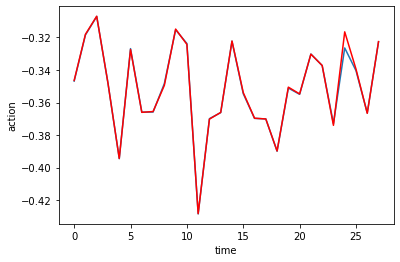

In [15]:
plt.plot(a_star_approx)
plt.plot(a_star_exact, color='red')
plt.xlabel('time')
plt.ylabel('action');

In [16]:
a_star_exact = (mu[t] - r) / (2 * lmbda * var[t])

In [17]:
a_star_exact

-0.32253962186045404

In [18]:
negative_reward(mu[t], var[t], a_star_exact, r, lmbda)

-0.011318382170844328

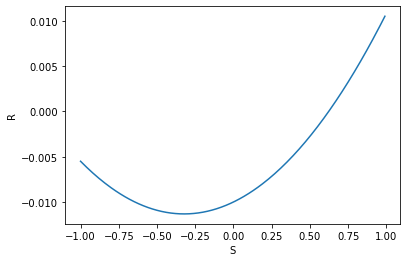

In [19]:
a_ = np.arange(-1, 1, 0.01)
plt.plot(a_, negative_reward(mu[t], var[t], a_, r, lmbda))
plt.xlabel('S')
plt.ylabel('R');

(-1, 1)

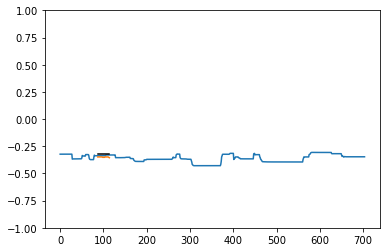

In [20]:
plt.plot(a_mean)
plt.plot(x_grid, a_star_)
plt.plot(x_grid, np.ones(len(x_grid)) * a_star_exact, color='black')
plt.ylim([-1, 1])

optimal action depends on lambda